In [4]:
from google.colab import drive
drive.mount('/content/drive')


import numpy as np
import pandas as pd
import os
base_path = "/content/drive/MyDrive/Breast Cancer/dataset/train"
categories = ['0', '1']
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,image_path,label
0,/content/drive/MyDrive/Breast Cancer/dataset/t...,0
1,/content/drive/MyDrive/Breast Cancer/dataset/t...,0
2,/content/drive/MyDrive/Breast Cancer/dataset/t...,0
3,/content/drive/MyDrive/Breast Cancer/dataset/t...,0
4,/content/drive/MyDrive/Breast Cancer/dataset/t...,0


<ipython-input-5-d1f79ac340b7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="viridis", ax=ax)


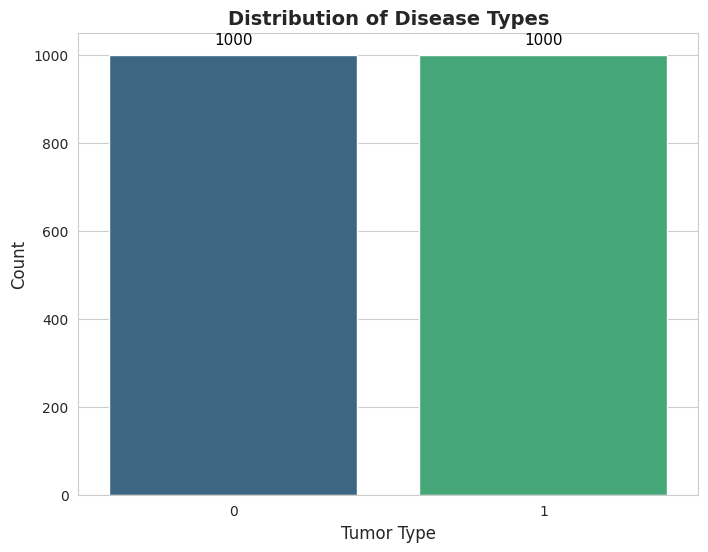

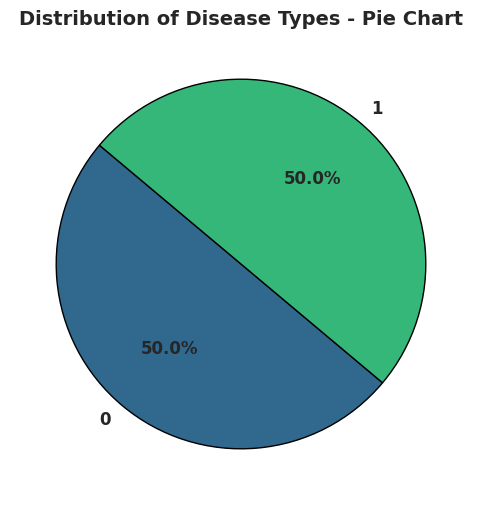

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)

ax.set_title("Distribution of Disease Types", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.show()

label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.color_palette("viridis", len(label_counts))

ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
       startangle=140, colors=colors, textprops={'fontsize': 12, 'weight':
'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 1})

ax.set_title("Distribution of Disease Types - Pie Chart", fontsize=14,
fontweight='bold')

plt.show()



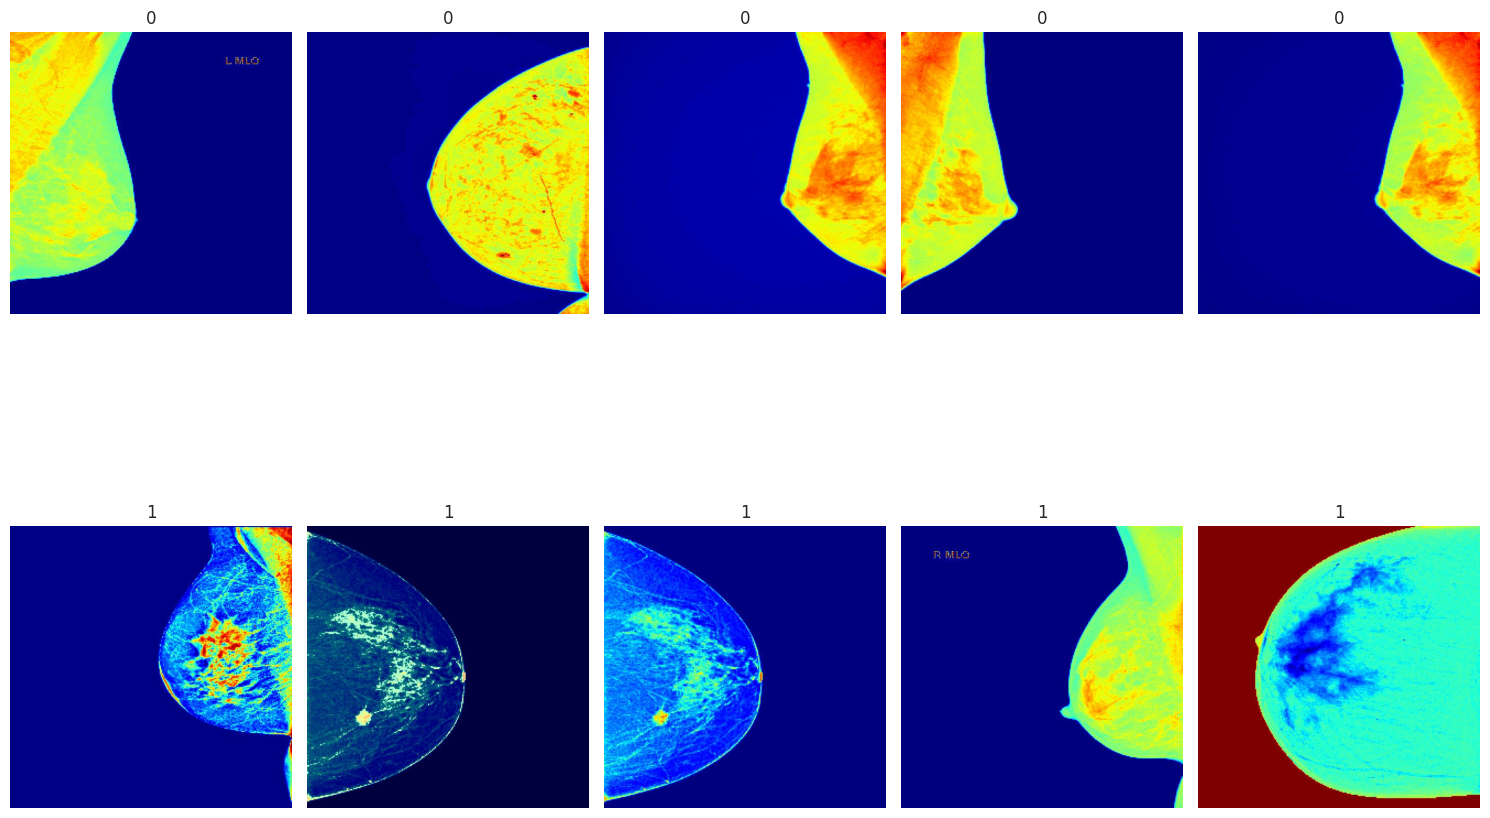

In [6]:
import cv2

num_images = 5

plt.figure(figsize=(15, 12))

for i, category in enumerate(categories):
    category_images = df[df['label'] ==
category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show()

In [8]:
df_resampled = df
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
import warnings
warnings.filterwarnings("ignore")
print ('check')

check


In [9]:
train_df_new, temp_df_new = train_test_split(
df_resampled,
train_size=0.8,
shuffle=True,
random_state=42,
stratify=df_resampled['label']
)
valid_df_new, test_df_new = train_test_split(
temp_df_new,
test_size=0.5,
shuffle=True,
random_state=42,
stratify=temp_df_new['label']
)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
batch_size = 16
img_size = (512, 512)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)
train_gen_new = tr_gen.flow_from_dataframe(
train_df_new,
x_col='image_path',
y_col='label',
target_size=img_size,
class_mode='binary',
color_mode='rgb',
shuffle=True,
batch_size=batch_size
)
valid_gen_new = ts_gen.flow_from_dataframe(
valid_df_new,
x_col='image_path',
y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 1600 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [24]:
class ContinuousLayer(layers.Layer):
    def __init__(self, kernel_size=5, num_basis=10, output_channels=16,
**kwargs):
        super(ContinuousLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.num_basis = num_basis
        self.output_channels = output_channels
        self.centers = self.add_weight(
            name='centers',
            shape=(num_basis, 2),
            initializer='random_normal',
            trainable=True
        )
        self.widths = self.add_weight(
            name='widths',
            shape=(num_basis,),
            initializer='ones',
            trainable=True,
            constraint=tf.keras.constraints.NonNeg()
        )
        self.kernel_weights = self.add_weight(
            name='kernel_weights',
            shape=(kernel_size, kernel_size, channels, output_channels),
            initializer='glorot_normal',
            trainable=True
        )
    # Move call method inside the class definition
    def call(self, inputs):
        height, width = img_size
        x = tf.range(0, height, 1.0)
        y = tf.range(0, width, 1.0)
        x_grid, y_grid = tf.meshgrid(x, y)
        grid = tf.stack([x_grid, y_grid], axis=-1)

        basis = []
        for i in range(self.num_basis):
            center = self.centers[i]
            width = self.widths[i]
            dist = tf.reduce_sum(((grid - center) / width) ** 2, axis=-1)
            basis_i = tf.exp(-dist)
            basis.append(basis_i)
        basis = tf.stack(basis, axis=-1)

        basis_weights = tf.reduce_mean(basis, axis=[0, 1])
        basis_weights = tf.nn.softmax(basis_weights)
        basis_weights = basis_weights[:, tf.newaxis, tf.newaxis, tf.newaxis,
tf.newaxis]

        modulated_kernel = self.kernel_weights * tf.reduce_sum(basis_weights,
axis=0)

        output = tf.nn.conv2d(
            inputs,
            modulated_kernel,
            strides=[1, 1, 1, 1],
            padding='SAME'
        )

        return output
    # Move compute_output_shape inside the class definition
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2],
self.output_channels)
    # Move smoothness_penalty inside the class definition
    def smoothness_penalty(self):
        grad_x = tf.reduce_mean(tf.square(self.kernel_weights[1:, :, :, :] -
self.kernel_weights[:-1, :, :, :]))
        grad_y = tf.reduce_mean(tf.square(self.kernel_weights[:, 1:, :, :] -
self.kernel_weights[:, :-1, :, :]))
        return grad_x + grad_y

# Move VariationalLoss class definition here
class VariationalLoss(tf.keras.losses.Loss): # Inherit from tf.keras.losses.Loss
    def __init__(self, model, lambda1=0.01, lambda2=1.0):
        super(VariationalLoss, self).__init__()
        self.model = model
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.bce = tf.keras.losses.BinaryCrossentropy()

    def call(self, y_true, y_pred):
        smoothness_penalty = 0
        for layer in self.model.layers:
            if isinstance(layer, ContinuousLayer):
                smoothness_penalty += layer.smoothness_penalty()
        prediction_loss = self.bce(y_true, y_pred)
        return self.lambda2 * prediction_loss + self.lambda1 * smoothness_penalty


def build_continuous_model():
    inputs = layers.Input(shape=img_shape)
    x = ContinuousLayer(kernel_size=5, num_basis=10, output_channels=16)(inputs)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    return model

model = build_continuous_model()

model.compile(
    optimizer='adam',
    loss=VariationalLoss(model=model, lambda1=0.01, lambda2=1.0),
    metrics=['accuracy']
)

history = model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_gen_new)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 599s 6s/step - accuracy: 0.5320 - loss: 6.9998 - val_accuracy: 0.5400 - val_loss: 0.6886
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 578s 6s/step - accuracy: 0.6438 - loss: 0.6303 - val_accuracy: 0.6550 - val_loss: 0.6253
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 579s 6s/step - accuracy: 0.8347 - loss: 0.4100 - val_accuracy: 0.7200 - val_loss: 0.5480
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 581s 6s/step - accuracy: 0.9117 - loss: 0.2005 - val_accuracy: 0.7250 - val_loss: 0.5661
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 579s 6s/step - accuracy: 0.9539 - loss: 0.1222 - val_accuracy: 0.7550 - val_loss: 0.6144
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - accuracy: 0.9825 - loss: 0.0633 - val_accuracy: 0.7100 - val_loss: 0.6754
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 582s 6s/step - accuracy: 0.9846 - loss: 0.0595 - val_accuracy: 0.7250 - val_loss: 0.6882
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 579s 6s/step - accuracy: 0.9867 - loss: 0.0483 - val_accu

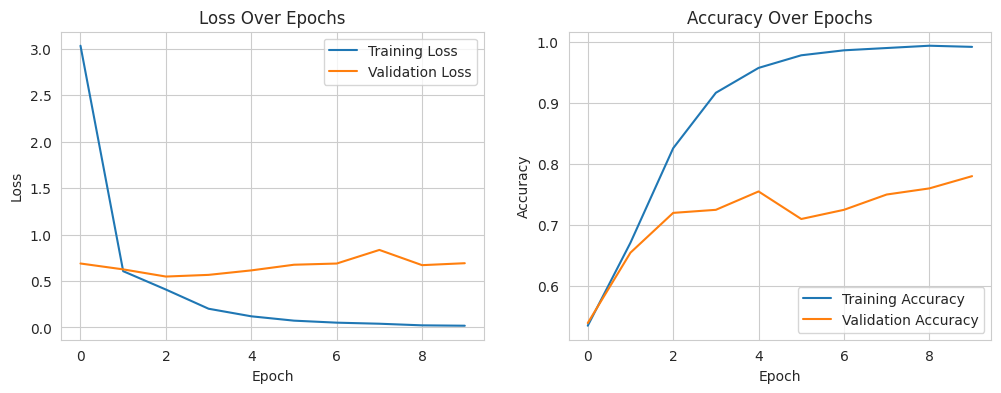

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np
y_pred = model.predict(test_gen_new)
y_pred_binary = (y_pred > 0.5).astype(int)
y_true = test_gen_new.classes
cm = confusion_matrix(y_true, y_pred_binary).ravel()
print("Confusion Matrix (TN, FP, FN, TP):", cm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
Confusion Matrix (TN, FP, FN, TP): [66 34 30 70]


In [27]:
class_names = list(test_gen_new.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary, target_names=class_names))



Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       100
           1       0.67      0.70      0.69       100

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200

